In [1]:
%cat /proc/cpuinfo

UsageError: Line magic function `%cat` not found.


In [ ]:
%cat /proc/meminfo

# Libraries

In [2]:
%pip install psutil --quiet
%pip install gputil --quiet
%pip install faiss-cpu --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from langchain.chains import RetrievalQA
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.agents.agent_toolkits import create_sql_agent
from langchain.chat_models import ChatOpenAI, ChatCohere
from langchain.embeddings import CohereEmbeddings, OpenAIEmbeddings
from langchain.sql_database import SQLDatabase
from langchain.chains import RetrievalQA
from langchain.agents import AgentType
from langchain.vectorstores import Pinecone, FAISS, Chroma
from langchain.embeddings import CohereEmbeddings, OpenAIEmbeddings
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers.document_compressors import (
    EmbeddingsFilter,
    DocumentCompressorPipeline,
)
from langchain.prompts import PromptTemplate
from langchain.schema import LLMResult
from langchain.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers import ContextualCompressionRetriever
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, Dict
from itertools import product
import pandas as pd
import numpy as np
import pinecone
import os
import json
import time
import psutil
import GPUtil


C:\Users\Tolga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
C:\Users\Tolga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pinecone\index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Helper Functions

In [3]:
def chunk_up_documents(
    file_path: str,
    chunk_size: int = 1000,
    chunk_overlap: int = 100,
):
    documents = []
    for file in os.listdir(file_path):
        if file.endswith(".pdf"):
            pdf_path = file_path + file
            loader = PyPDFLoader(pdf_path)
            documents.extend(loader.load())

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        separators="\n\n", chunk_size=chunk_size, chunk_overlap=chunk_overlap
    )

    chunked_docs = text_splitter.split_documents(documents)
    return chunked_docs

def filter_embeddings(
    search_object, embedding_model, s_threshold: int = 0.5, r_threshold: int = 0.76
):
    relevancy_filter = EmbeddingsFilter(embeddings=embedding_model, s_threshold=0.5)
    redundant_filter = EmbeddingsRedundantFilter(
        embeddings=embedding_model, r_threshold=0.76
    )
    pipeline_compressor = DocumentCompressorPipeline(
        transformers=[redundant_filter, relevancy_filter]
    )
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=pipeline_compressor, base_retriever=search_object.as_retriever()
    )
    return compression_retriever

def run_qa(
    chain_type: str,
    retriever,
    question: str
    ):
  chain = RetrievalQA.from_chain_type(
    llm=ChatCohere(
      cohere_api_key=os.environ.get("cohere_api"),
      temperature=1e-10,
    ),
    chain_type=chain_type,
    retriever=retriever,
  )
  return chain.run(question)

def measure_resource_usage(function: Callable, **parameters):
    start_time = time.time()
    cpu_before = psutil.cpu_percent(interval=1)
    ram_before = psutil.virtual_memory().percent
    gpu_before = GPUtil.getGPUs()[0].load * 100

    query_result = function(**parameters)
    time.sleep(2)

    cpu_after = psutil.cpu_percent(interval=1)
    ram_after = psutil.virtual_memory().percent
    gpu_after = GPUtil.getGPUs()[0].load * 100
    end_time = time.time()

    runtime = end_time - start_time
    cpu_usage_percentage = np.abs(round(cpu_after,4) - round(cpu_before,4))
    ram_usage_percentage = np.abs(round(ram_after,4) - round(ram_before,4))
    gpu_usage_percentage = np.abs(round(gpu_after,4) - round(gpu_before,4))

    print(f"Runtime: {runtime} seconds")
    print(f"CPU Usage: {cpu_usage_percentage}%")
    print(f"RAM Usage: {ram_usage_percentage}%")
    print(f"GPU Usage: {gpu_usage_percentage}%")

    return runtime, cpu_usage_percentage, gpu_usage_percentage, ram_usage_percentage, len(query_result), query_result

# Preprocessing

In [6]:
cohere_embedding = CohereEmbeddings(
    cohere_api_key=os.environ.get("cohere_api"),
    model="embed-multilingual-v2.0"
)

chat_model = ChatCohere(
      cohere_api_key=os.environ.get("cohere_api"),
      temperature=1e-10,
  )

openai_embedding = OpenAIEmbeddings(
    openai_api_key=os.environ.get("OPENAI_API_KEY"),
    model="text-embedding-ada-002"
)

openai_chat_model = ChatOpenAI(
    openai_api_key=os.environ.get("OPENAI_API_KEY"),
    model="gpt-3.5-turbo",
    temperature=0
)

In [8]:
document_chunks = chunk_up_documents(
    file_path=os.environ.get("pdf_path"),
    chunk_size=1000,
    chunk_overlap=50
)

In [4]:
question_tr = "Global MD Portföy İkinci Değişken fonunun yatırım riskleri nelerdir?"
question_eng = "What are the investment risks of 'GLOBAL MD Portföy İkinci Değişken' fund?"

# ChromaDB

In [10]:
# save the embedded chunks as a vector database
chromadb = Chroma.from_documents(document_chunks, cohere_embedding, persist_directory="./chromadb_new")
chromadb.persist()

In [7]:
# Load from saved chromadb vector database
loaded_chromadb = Chroma(persist_directory="./chromadb_new", embedding_function=cohere_embedding)

In [12]:
context_compressor_retriever = filter_embeddings(
    search_object=loaded_chromadb,
    embedding_model=cohere_embedding,
    s_threshold=0.5,
    r_threshold=0.76
)

In [ ]:

chain_type = ['stuff', 'map_reduce', 'refine', 'map_rerank']
similarity_threshold = [0.5, 0.6]
redundancy_threshold = [0.7, 0.8]
usage_list = []

for ctype, st, rt in product(chain_type, similarity_threshold, redundancy_threshold):
    print(f"\nProcessing {ctype} with similarity_threshold={st} and redundancy_threshold={rt}")

    # Assuming filter_embeddings works correctly
    compression_retriever = filter_embeddings(
        search_object=loaded_chromadb,
        embedding_model=cohere_embedding,
        s_threshold=st,
        r_threshold=rt
    )

    # Measure resource usage for the current iteration
    result = measure_resource_usage(
        run_qa,
        chain_type=ctype,
        retriever=compression_retriever,
        question=question_tr,
    )
    
    # Create a new dictionary for each iteration
    usage_dict = {}
    usage_dict['similarity_threshold'] = st
    usage_dict['redundancy_threshold'] = rt
    usage_dict['chain_method'] = ctype
    usage_dict["run_time"] = result[0]
    usage_dict["cpu_usage"] = result[1]
    usage_dict["ram_usage"] = result[3]
    usage_dict["token_length"] = result[4]
    usage_dict["output"] = result[5]

    # Append the dictionary to the list
    usage_list.append(usage_dict)

print("\nFinal Usage List:")
print(usage_list)

In [ ]:
usage_df_1 = pd.DataFrame(usage_list)
usage_df_1.sort_values(by="run_time", ascending=False)

,similarity_threshold,redundancy_threshold,chain_method,run_time,cpu_usage,ram_usage,token_length,output
9,0.5,0.8,refine,38.243132,2.9,0.2,2371,Global MD Portföy Ikinci Değişken (GMD) is an ...
8,0.5,0.7,refine,35.067605,3.0,0.0,2227,Global MD Portföy Ikinci Değişken (GMD) is an ...
10,0.6,0.7,refine,33.572999,2.1,0.1,2462,Global MD Portföy Ikinci Değişken (GMD) is an ...
11,0.6,0.8,refine,31.935348,2.1,0.2,2227,Global MD Portföy Ikinci Değişken (GMD) is an ...
7,0.6,0.8,map_reduce,22.581461,1.2,0.1,982,I understand that you seek to know the investm...
4,0.5,0.7,map_reduce,21.128124,2.4,0.0,982,I understand that you seek to know the investm...
6,0.6,0.7,map_reduce,20.823301,2.3,0.1,948,I understand that you seek to know the investm...
5,0.5,0.8,map_reduce,18.024768,1.9,0.1,515,I understand that the provided text is in Turk...
12,0.5,0.7,map_rerank,12.508131,1.8,0.0,0,
15,0.6,0.8,map_rerank,12.273896,1.5,0.0,0,


# Faiss

In [15]:
# save the embedded chunks as a vector database
faiss_db = FAISS.from_documents(document_chunks, cohere_embedding)
faiss_db.save_local("faissdb_new")

In [9]:
loaded_faissdb = FAISS.load_local("./faissdb_new", cohere_embedding)

RuntimeError: Error in __cdecl faiss::FileIOReader::FileIOReader(const char *) at D:\a\faiss-wheels\faiss-wheels\faiss\faiss\impl\io.cpp:68: Error: 'f' failed: could not open faissdb_new\index.faiss for reading: No such file or directory

In [17]:
context_compressor_retriever_2 = filter_embeddings(
    search_object=loaded_faissdb,
    embedding_model=cohere_embedding,
    s_threshold=0.5,
    r_threshold=0.76
)

In [ ]:

chain_type = ['stuff', 'map_reduce', 'refine', 'map_rerank']
similarity_threshold = [0.5, 0.6]
redundancy_threshold = [0.7, 0.8]
usage_list = []

for ctype, st, rt in product(chain_type, similarity_threshold, redundancy_threshold):
    print(f"\nProcessing {ctype} with similarity_threshold={st} and redundancy_threshold={rt}")

    # Assuming filter_embeddings works correctly
    compression_retriever = filter_embeddings(
        search_object=loaded_faissdb,
        embedding_model=cohere_embedding,
        s_threshold=st,
        r_threshold=rt
    )

    # Measure resource usage for the current iteration
    result = measure_resource_usage(
        run_qa,
        chain_type=ctype,
        retriever=compression_retriever,
        question=question_tr,
    )
    
    # Create a new dictionary for each iteration
    usage_dict = {}
    usage_dict['similarity_threshold'] = st
    usage_dict['redundancy_threshold'] = rt
    usage_dict['chain_method'] = ctype
    usage_dict["run_time"] = result[0]
    usage_dict["cpu_usage"] = result[1]
    usage_dict["ram_usage"] = result[3]
    usage_dict["token_length"] = result[4]
    usage_dict["output"] = result[5]

    # Append the dictionary to the list
    usage_list.append(usage_dict)

print("\nFinal Usage List:")
print(usage_list)

In [ ]:
usage_df_2 = pd.DataFrame(usage_list)
usage_df_2.sort_values(by="run_time", ascending=False)

,similarity_threshold,redundancy_threshold,chain_method,run_time,cpu_usage,ram_usage,token_length,output
11,0.6,0.8,refine,25.146491,1.4,0.1,2227,Global MD Portföy Ikinci Değişken (GMD) is an ...
8,0.5,0.7,refine,24.650336,0.7,0.1,2239,Global MD Portföy Ikinci Değişken (GMD) is an ...
10,0.6,0.7,refine,24.615048,1.9,0.1,2227,Global MD Portföy Ikinci Değişken (GMD) is an ...
9,0.5,0.8,refine,24.597791,1.5,0.1,2227,Global MD Portföy Ikinci Değişken (GMD) is an ...
4,0.5,0.7,map_reduce,20.436790,6.1,0.3,515,I understand that the provided text is in Turk...
7,0.6,0.8,map_reduce,19.607908,2.0,0.1,515,I understand that the provided text is in Turk...
15,0.6,0.8,map_rerank,19.567800,2.1,0.2,0,
5,0.5,0.8,map_reduce,17.993165,1.3,0.1,515,I understand that the provided text is in Turk...
6,0.6,0.7,map_reduce,17.951498,2.5,0.2,515,I understand that the provided text is in Turk...
3,0.6,0.8,stuff,15.245089,0.5,0.2,449,"I'm sorry, but I cannot provide a thorough ans..."


# Pinecone

In [47]:
pinecone.init(
        api_key="PINECONE_API",
        environment=os.environ.get("pinecone_environment_value"),
        )
searcher = Pinecone.from_existing_index(
        index_name="pinecone-test", embedding=cohere_embedding
    )

In [22]:
context_compressor_retriever_3 = filter_embeddings(
    search_object=searcher,
    embedding_model=cohere_embedding,
    s_threshold=0.5,
    r_threshold=0.76
)

In [ ]:

chain_type = ['stuff', 'map_reduce', 'refine', 'map_rerank']
similarity_threshold = [0.5, 0.6]
redundancy_threshold = [0.7, 0.8]
usage_list = []

for ctype, st, rt in product(chain_type, similarity_threshold, redundancy_threshold):
    print(f"\nProcessing {ctype} with similarity_threshold={st} and redundancy_threshold={rt}")

    # Assuming filter_embeddings works correctly
    compression_retriever = filter_embeddings(
        search_object=searcher,
        embedding_model=cohere_embedding,
        s_threshold=st,
        r_threshold=rt
    )

    # Measure resource usage for the current iteration
    result = measure_resource_usage(
        run_qa,
        chain_type=ctype,
        retriever=compression_retriever,
        question=question_tr,
    )
    
    # Create a new dictionary for each iteration
    usage_dict = {}
    usage_dict['similarity_threshold'] = st
    usage_dict['redundancy_threshold'] = rt
    usage_dict['chain_method'] = ctype
    usage_dict["run_time"] = result[0]
    usage_dict["cpu_usage"] = result[1]
    usage_dict["ram_usage"] = result[3]
    usage_dict["token_length"] = result[4]
    usage_dict["output"] = result[5]

    # Append the dictionary to the list
    usage_list.append(usage_dict)

print("\nFinal Usage List:")
print(usage_list)

In [ ]:
usage_df_3 = pd.DataFrame(usage_list)
usage_df_3.sort_values(by="run_time", ascending=True)

,similarity_threshold,redundancy_threshold,chain_method,run_time,cpu_usage,ram_usage,token_length,output
12,0.5,0.7,map_rerank,12.780085,3.1,0.0,0,
15,0.6,0.8,map_rerank,13.872531,1.8,0.0,0,
1,0.5,0.8,stuff,14.047843,3.0,0.6,143,"Sorry, the provided information is not enough ..."
13,0.5,0.8,map_rerank,14.427377,0.6,0.1,0,
0,0.5,0.7,stuff,22.371097,2.2,0.1,143,"Sorry, the provided information is not enough ..."
14,0.6,0.7,map_rerank,24.837060,2.5,0.1,0,
11,0.6,0.8,refine,24.883296,2.6,0.0,863,The investment risks associated with the Globa...
9,0.5,0.8,refine,25.839001,2.1,0.1,863,The investment risks associated with the Globa...
2,0.6,0.7,stuff,28.836792,0.9,0.1,143,"Sorry, the provided information is not enough ..."
6,0.6,0.7,map_reduce,29.083289,3.1,0.1,596,"Based on the provided information, the Global ..."


# Results

In [ ]:
combined_df = pd.concat([usage_df_1, usage_df_2, usage_df_3], axis=0, keys=["ChromaDB","Faiss","Pinecone"])
combined_df.sort_values(by="output", ascending=True).to_excel("vdb_benchmark_metrics.xlsx")
#

In [176]:
test_df = combined_df.reset_index()
test_df = test_df.rename(columns={"level_0":"vdb_type"}).drop(["level_1"], axis=1)
test_df.sort_values(by="run_time", ascending=True).to_excel("sorted_benchmark_results.xlsx")

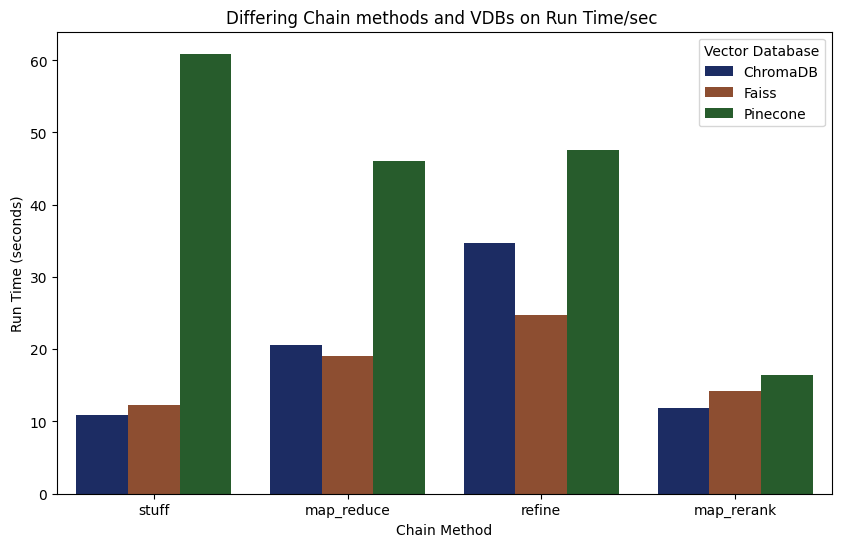

In [179]:
plt.figure(figsize=(10, 6))
dark_grey_palette = sns.color_palette("dark", desat=0.75)
sns.barplot(x='chain_method', y='run_time', data=test_df, hue='vdb_type', palette=dark_grey_palette, errorbar=None)
plt.xlabel('Chain Method')
plt.ylabel('Run Time (seconds)')
plt.title("Differing Chain methods and VDBs on Run Time/sec ")
plt.legend(title='Vector Database')
plt.show()

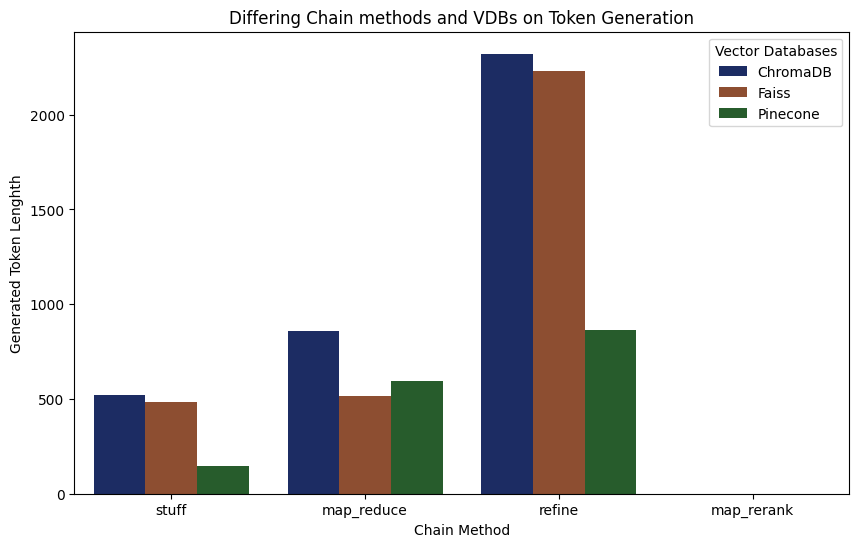

In [153]:
plt.figure(figsize=(10, 6))
dark_grey_palette = sns.color_palette("dark", desat=0.75)
sns.barplot(x='chain_method', y='token_length', data=test_df, hue='vdb_type', palette=dark_grey_palette, errorbar=None,)
plt.xlabel('Chain Method')
plt.ylabel('Generated Token Lenghth')
plt.title("Differing Chain methods and VDBs on Token Generation")
plt.legend(title='Vector Databases')
plt.show()

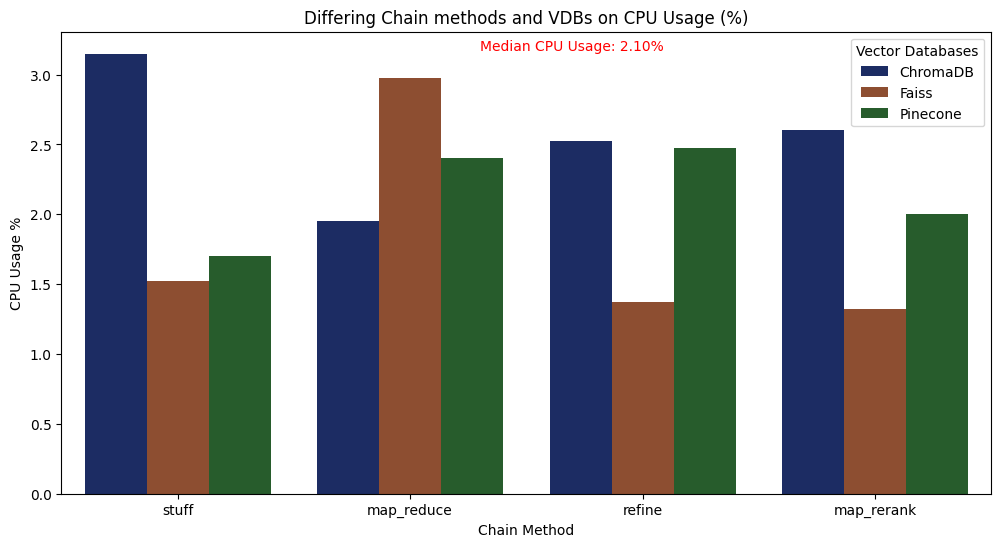

In [180]:
plt.figure(figsize=(12, 6))
dark_grey_palette = sns.color_palette("dark", desat=0.75)
sns.barplot(x='chain_method', y="cpu_usage", data=test_df, hue='vdb_type', palette=dark_grey_palette, errorbar=None,)
plt.xlabel('Chain Method')
plt.ylabel('CPU Usage %')
plt.title("Differing Chain methods and VDBs on CPU Usage (%)")
plt.legend(title='Vector Databases')
mean_cpu = np.median(test_df['cpu_usage'])
plt.text(0.45, 0.96, f'Median CPU Usage: {mean_cpu:.2f}%', transform=plt.gca().transAxes, fontsize=10, color='red')
plt.show()

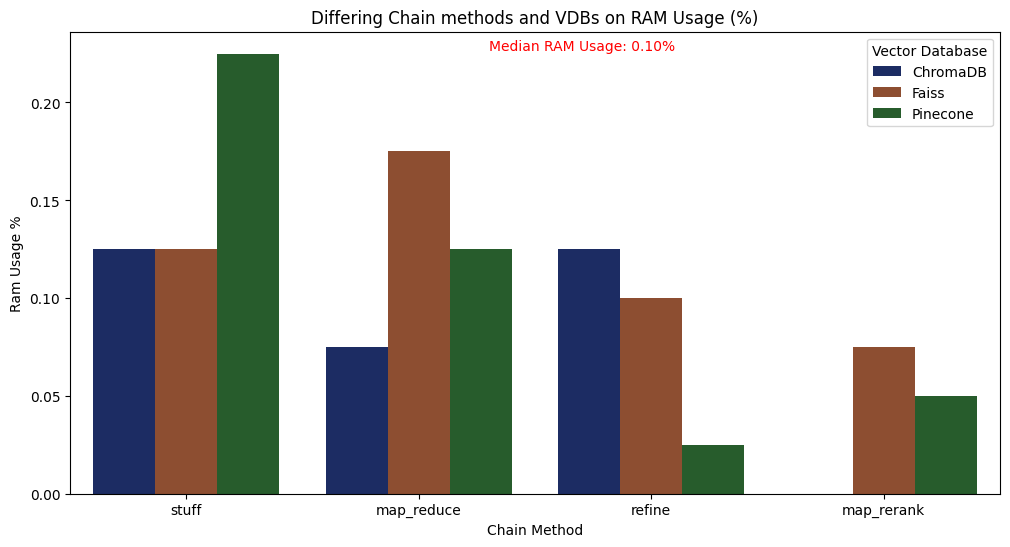

In [181]:
plt.figure(figsize=(12, 6))
dark_grey_palette = sns.color_palette("dark", desat=0.75)
sns.barplot(x='chain_method', y="ram_usage", data=test_df, hue='vdb_type', palette=dark_grey_palette, errorbar=None,)
plt.xlabel('Chain Method')
plt.ylabel('Ram Usage %')
plt.title("Differing Chain methods and VDBs on RAM Usage (%)")
plt.legend(title='Vector Database')
mean_ram = np.median(test_df['ram_usage'])
plt.text(0.45, 0.96, f'Median RAM Usage: {mean_ram:.2f}%', transform=plt.gca().transAxes, fontsize=10, color='red')
plt.show()